# Brief analysis on model fit with a larger data set

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import warnings
from pathlib import Path
from time import time
from typing import Final

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import scipy.stats as st
import seaborn as sns

In [3]:
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.io import DataFile, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Data

In [5]:
def read_posterior_summary(fpath: Path) -> pd.DataFrame:
    """Read in a posterior summary data frame."""
    post_summ = pd.read_csv(fpath).assign(
        parameter_name=lambda d: [x.split("[")[0] for x in d.parameter]
    )
    return post_summ

In [6]:
hnb_model_dir = models_dir() / "hierarchical-nb_PYMC3_MCMC"
posterior_summary_path = hnb_model_dir / "posterior-summary.csv"
posterior_summary = read_posterior_summary(posterior_summary_path)
posterior_summary.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name
0,z,0.042,0.005,0.035,0.050,0.000,0.000,142.0,404.0,1.02,z
1,a[0],0.314,0.087,0.165,0.439,0.001,0.001,4659.0,2956.0,1.00,a
2,a[1],-0.004,0.060,-0.106,0.085,0.001,0.001,2523.0,3087.0,1.00,a
3,a[2],0.179,0.060,0.087,0.279,0.001,0.001,2254.0,2605.0,1.00,a
4,a[3],0.196,0.065,0.097,0.303,0.001,0.001,3222.0,2927.0,1.00,a


In [7]:
hnb_model_cls = HierarchcalNegativeBinomialModel()
dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_LARGE_SUBSAMPLE)
counts_data = dm.get_data().pipe(hnb_model_cls.data_processing_pipeline)
counts_data.head()

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_52644/3319598406.py:3: DtypeWarning: Columns (3,22) have mixed types.Specify dtype option on import or set low_memory=False.


,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age,counts_final_total,counts_initial_total,counts_final_rpm,counts_initial_adj
0,AAAGCCCAGGAGTATGGGAG,LS513-311Cas9_RepA_p6_batch2,0.594321,2,chr2_130522105_-,CFC1B,broad,True,2,130522105,...,False,0.951337,colorectal,primary,True,63.0,35176093,1.072163e+06,13.309497,257.442323
1,ACTTGTCTCATGAACGTGAT,LS513-311Cas9_RepA_p6_batch2,0.475678,2,chr2_86917638_+,RGPD1,broad,True,2,86917638,...,False,0.949234,colorectal,primary,True,63.0,35176093,1.072163e+06,37.928490,766.756365
2,AGAAACTTCACCCCTTTCAT,LS513-311Cas9_RepA_p6_batch2,0.296108,2,chr16_18543661_+,NOMO2,broad,True,16,18543661,...,False,0.944648,colorectal,primary,True,63.0,35176093,1.072163e+06,29.513684,685.044642
3,AGCTGAGCGCAGGGACCGGG,LS513-311Cas9_RepA_p6_batch2,-0.020788,2,chr1_27012633_-,TENT5B,broad,True,1,27012633,...,False,0.961139,colorectal,primary,True,63.0,35176093,1.072163e+06,4.837834,142.977169
4,ATACTCCTGGGCTTTCGGAG,LS513-311Cas9_RepA_p6_batch2,-0.771298,2,chr2_130522124_+,CFC1B,broad,True,2,130522124,...,False,0.951337,colorectal,primary,True,63.0,35176093,1.072163e+06,14.588775,706.908890


In [8]:
data_coords = hnb_model_cls._model_coords(counts_data)

cell_line_lineage_map = (
    counts_data[["depmap_id", "lineage"]].drop_duplicates().reset_index(drop=True)
)

sgrna_gene_map = (
    counts_data[["sgrna", "hugo_symbol"]].drop_duplicates().reset_index(drop=True)
)

## Analysis

### Sampling diagnostics

#### R-hat

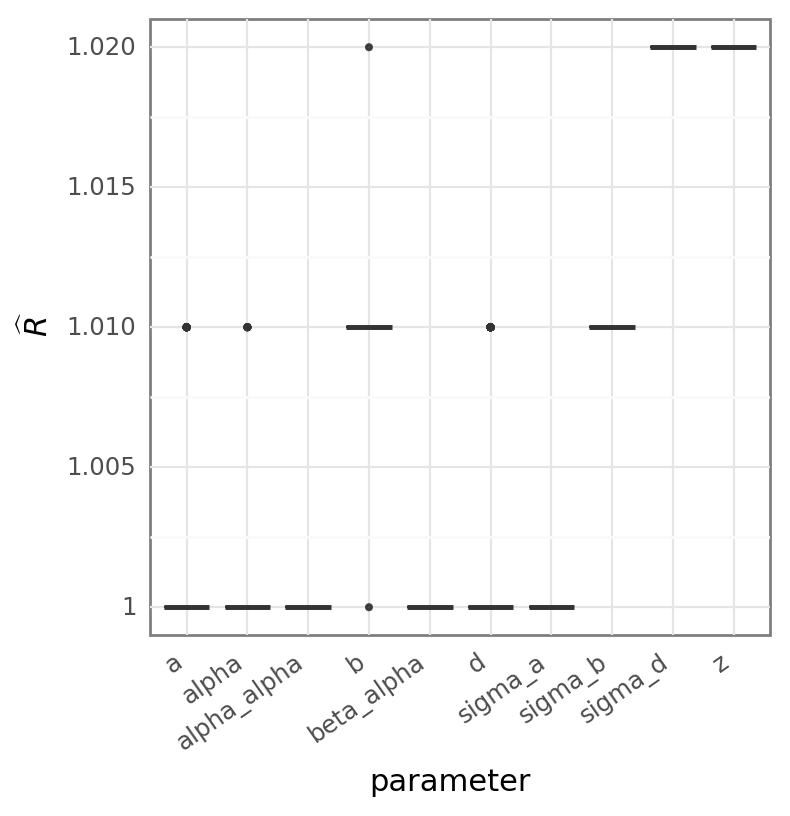

<ggplot: (364750836)>

In [9]:
(
    gg.ggplot(posterior_summary, gg.aes(x="parameter_name", y="r_hat"))
    + gg.geom_boxplot(outlier_size=0.6, outlier_alpha=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="$\widehat{R}$")
)

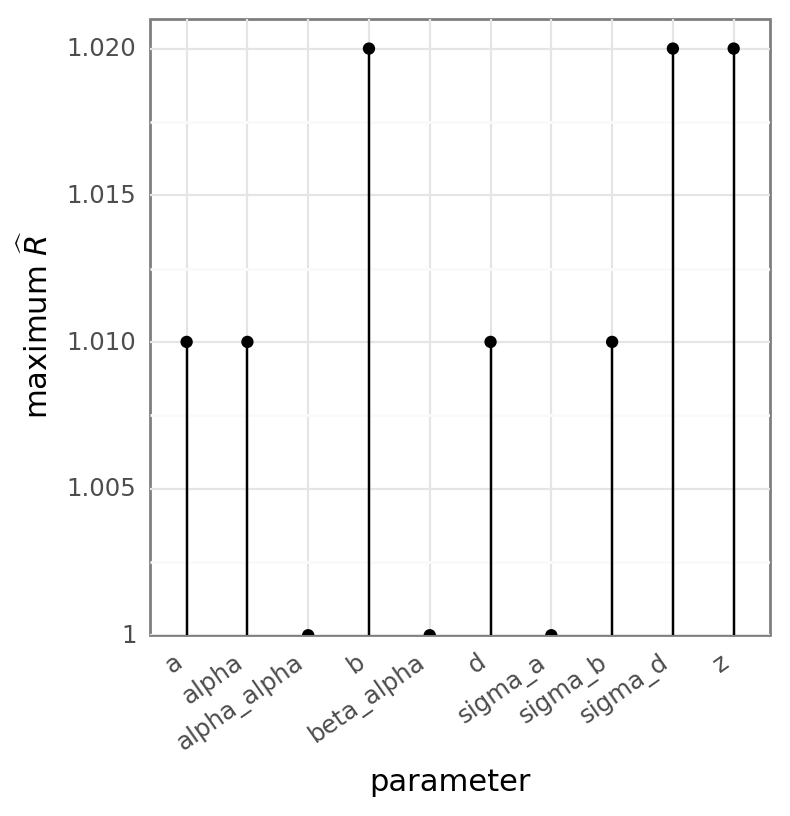

<ggplot: (362095583)>

In [10]:
max_r_hats = (
    posterior_summary.sort_values("r_hat", ascending=False)
    .groupby("parameter_name")
    .head(1)
)
(
    gg.ggplot(max_r_hats, gg.aes(x="parameter_name", y="r_hat"))
    + gg.geom_linerange(gg.aes(ymax="r_hat"), ymin=1)
    + gg.geom_point()
    + gg.scale_y_continuous(expand=(0, 0, 0.05, 0))
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="maximum $\widehat{R}$")
)

#### ESS

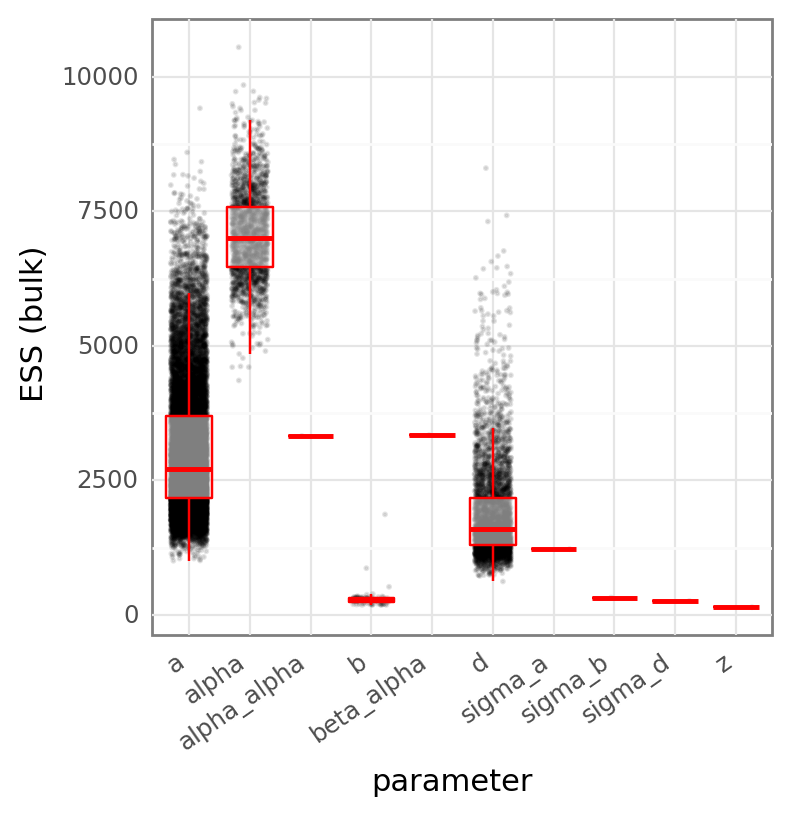

<ggplot: (364544850)>

In [11]:
(
    gg.ggplot(
        posterior_summary,
        gg.aes(x="parameter_name", y="ess_bulk"),
    )
    + gg.geom_jitter(alpha=0.1, size=0.2, width=0.3, height=0)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.5, color="red")
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="ESS (bulk)")
)

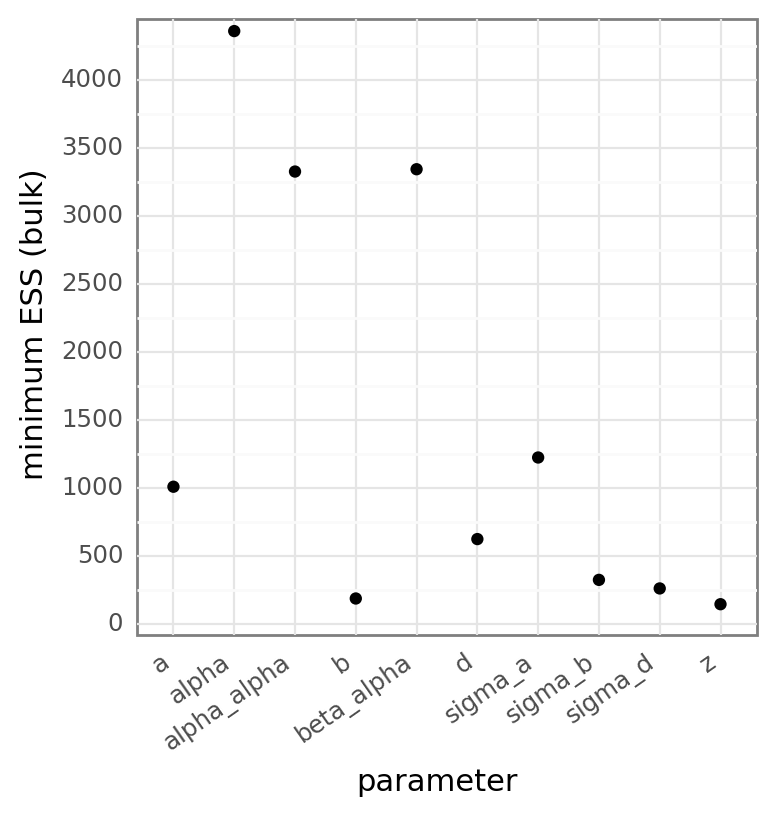

<ggplot: (362508788)>

In [12]:
min_ess = (
    posterior_summary.sort_values("ess_bulk", ascending=True)
    .groupby("parameter_name")
    .head(1)
)

_breaks = np.arange(0, 5000, 500)

(
    gg.ggplot(min_ess, gg.aes(x="parameter_name", y="ess_bulk"))
    + gg.geom_linerange(gg.aes(ymax="r_hat"), ymin=1)
    + gg.geom_point()
    + gg.scale_y_continuous(expand=(0.02, 0), breaks=_breaks)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="minimum ESS (bulk)")
)

### Parameter posteriors

#### $b$: cell line

In [13]:
lineage_pal: Final[dict[str, str]] = {"bone": "darkviolet", "colorectal": "green"}

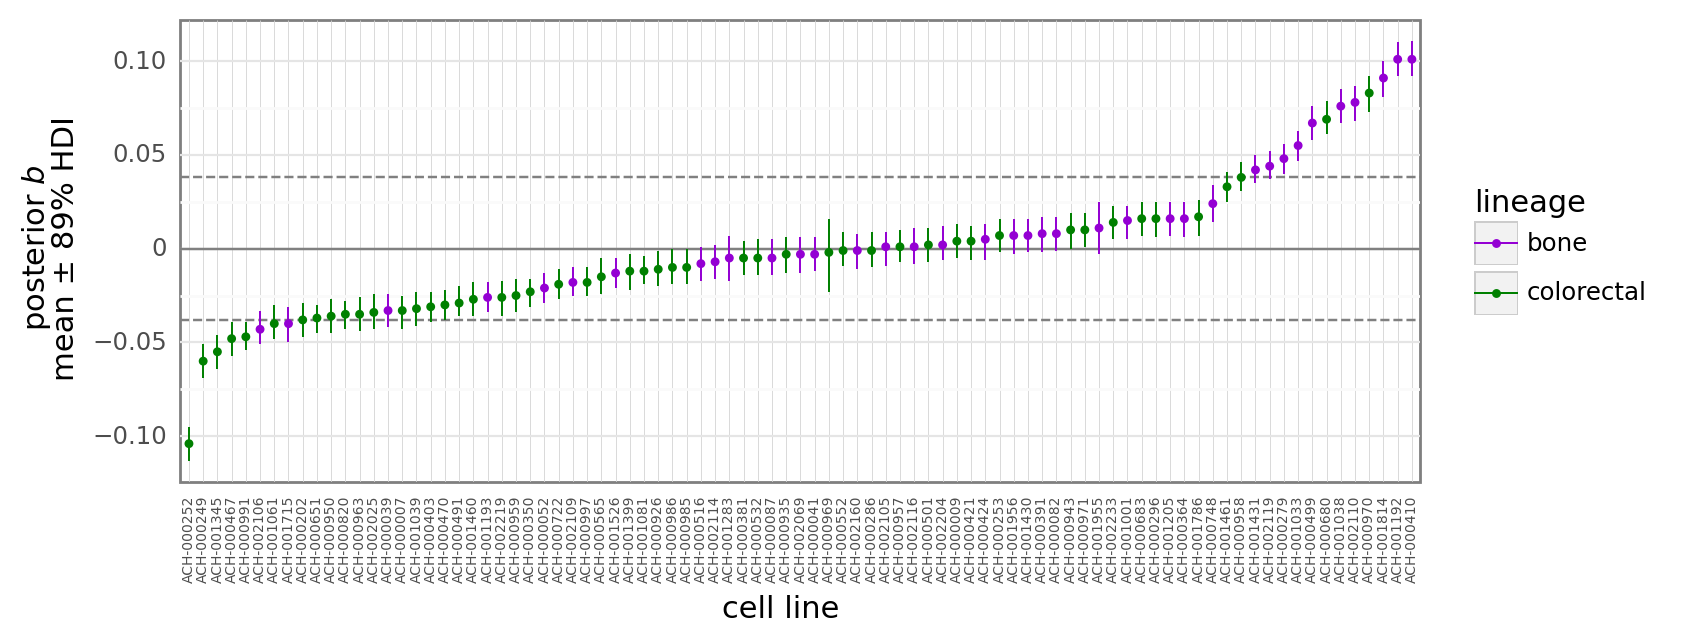

<ggplot: (363585518)>

In [14]:
sigma_b_map = posterior_summary.query("parameter_name == 'sigma_b'")["mean"].values[0]

b_posterior = (
    posterior_summary.query("parameter_name == 'b'")
    .reset_index(drop=True)
    .assign(depmap_id=data_coords["cell_line"])
    .merge(cell_line_lineage_map, on="depmap_id")
    .sort_values(["mean"])
    .assign(
        depmap_id=lambda d: pd.Categorical(
            d.depmap_id.values, categories=d.depmap_id.values, ordered=True
        )
    )
)

(
    gg.ggplot(b_posterior, gg.aes(x="depmap_id", y="mean"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_hline(yintercept=[-sigma_b_map, sigma_b_map], linetype="--", color="gray")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="lineage"), size=0.4
    )
    + gg.geom_point(gg.aes(color="lineage"), size=0.8)
    + gg.scale_color_manual(values=lineage_pal)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=5),
        panel_grid_major_x=gg.element_line(size=0.3, color="lightgray"),
        figure_size=(8, 3),
    )
    + gg.labs(x="cell line", y="posterior $b$\nmean ± 89% HDI")
)

#### $a$: sgRNA

In [15]:
a_posterior = (
    posterior_summary.query("parameter_name == 'a'")
    .reset_index(drop=True)
    .assign(sgrna=data_coords["sgrna"])
    .merge(sgrna_gene_map, on="sgrna")
)
a_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,sgrna,hugo_symbol
0,a[0],0.314,0.087,0.165,0.439,0.001,0.001,4659.0,2956.0,1.0,a,TGCGTTCCCGGACTTACCC,MYO18B
1,a[1],-0.004,0.060,-0.106,0.085,0.001,0.001,2523.0,3087.0,1.0,a,CGGACCAAACGGGGACACC,TMEM143
2,a[2],0.179,0.060,0.087,0.279,0.001,0.001,2254.0,2605.0,1.0,a,CTTGGCCGATTTGGTAACCA,PQBP1
3,a[3],0.196,0.065,0.097,0.303,0.001,0.001,3222.0,2927.0,1.0,a,AAGCTGGCTGGAAAGAAAAA,GBP1
4,a[4],0.173,0.078,0.058,0.304,0.001,0.001,3788.0,3091.0,1.0,a,ATAGGCCGCTCCGGGCATC,SMARCD1


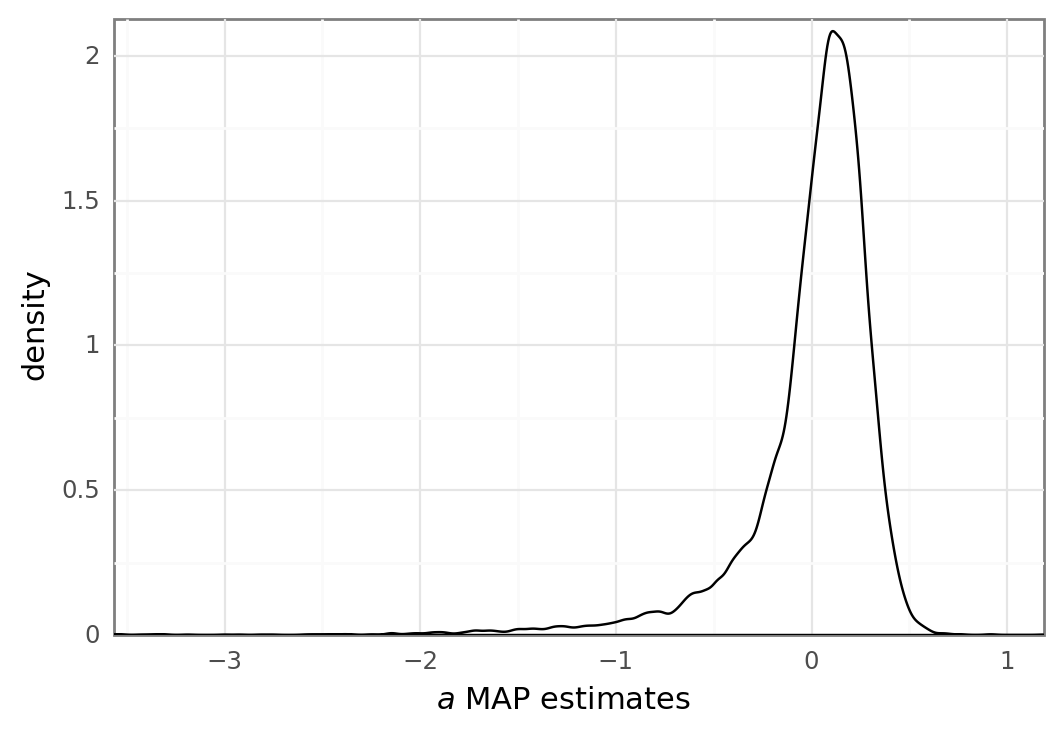

<ggplot: (363156502)>

In [16]:
(
    gg.ggplot(a_posterior, gg.aes(x="mean"))
    + gg.geom_density()
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(6, 4))
    + gg.labs(x="$a$ MAP estimates")
)

In [17]:
def min_max(df: pd.DataFrame, n: int, drop_idx: bool = True) -> pd.DataFrame:
    """Get the top and botton `n` rows of a data frame."""
    return pd.concat([df.head(n), df.tail(n)]).reset_index(drop=drop_idx)


_n_top = 20
a_min_max = (
    a_posterior.sort_values("mean")
    .pipe(min_max, n=_n_top)
    .assign(
        sgrna=lambda d: pd.Categorical(
            d.sgrna.values, categories=d.sgrna.values, ordered=True
        )
    )
)
a_min_max.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,sgrna,hugo_symbol
0,a[348],-3.567,0.145,-3.790,-3.337,0.002,0.001,5820.0,2632.0,1.0,a,AGTTCCTTCAACCTTTGAGA,PTCD3
1,a[9682],-3.536,0.149,-3.758,-3.285,0.002,0.001,5308.0,3123.0,1.0,a,TTTGGTTTCCTCTTTCCATG,OR7C2
2,a[16025],-3.531,0.142,-3.772,-3.311,0.002,0.001,5369.0,2937.0,1.0,a,ATTTTGATCCAAGGCAGAC,CPA3
3,a[349],-3.428,0.143,-3.645,-3.193,0.002,0.001,5352.0,3065.0,1.0,a,CTACGATTACCATCTCCATA,BAG4
4,a[6869],-3.379,0.137,-3.585,-3.154,0.002,0.001,5291.0,2788.0,1.0,a,CTTCAGGGTGAACATCCACC,PARVB


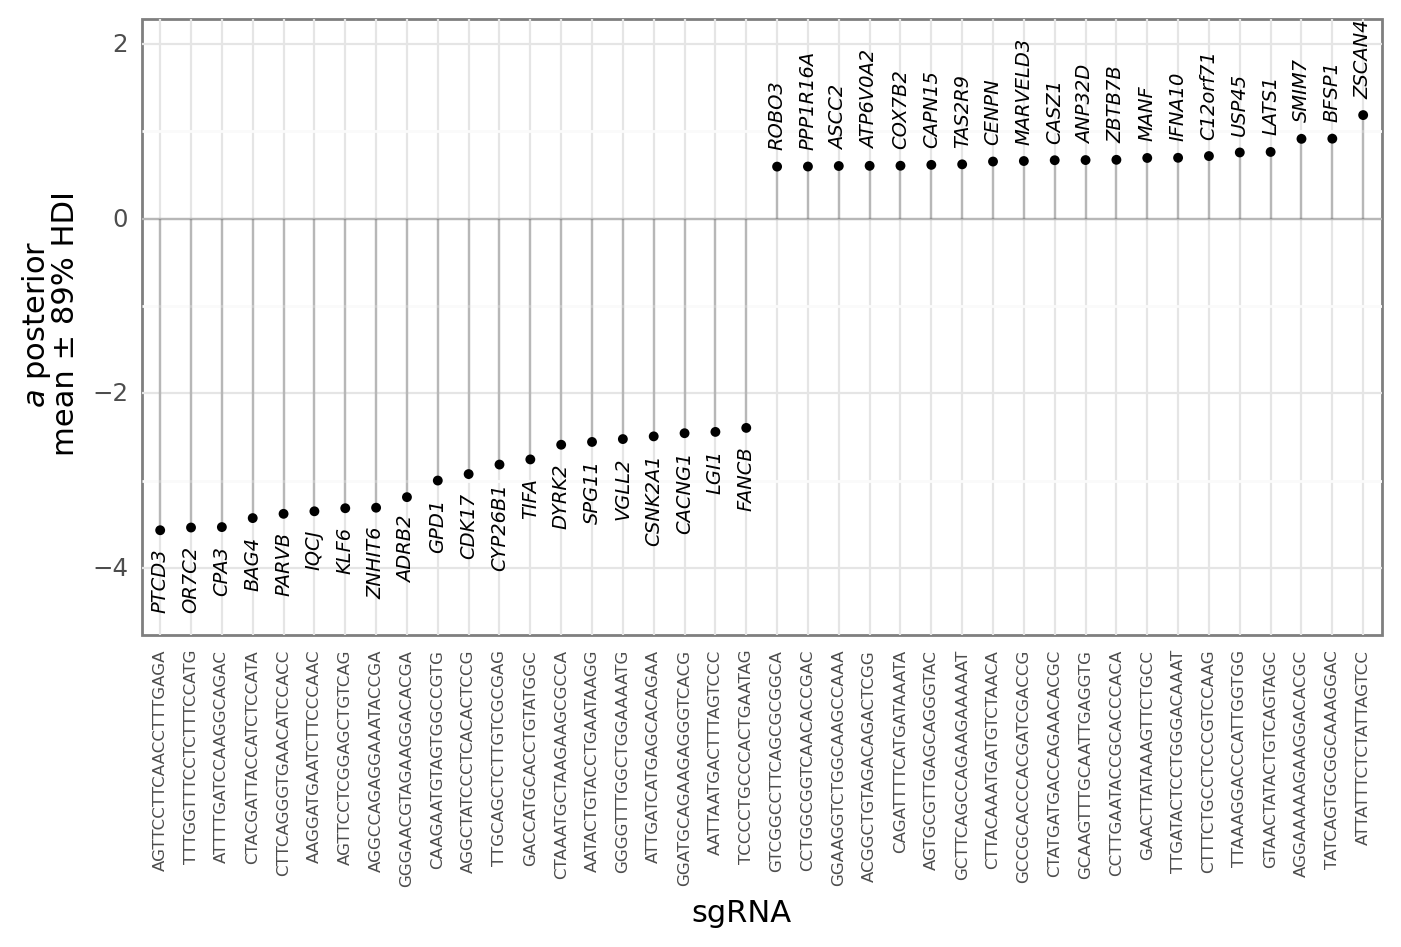

<ggplot: (352119646)>

In [18]:
_nudge_y = [-0.2 for _ in range(_n_top)] + [0.2 for _ in range(_n_top)]
_va = ["top" for _ in range(_n_top)] + ["bottom" for _ in range(_n_top)]
(
    gg.ggplot(a_min_max, gg.aes(x="sgrna", y="mean"))
    + gg.geom_hline(yintercept=0, alpha=0.2)
    + gg.geom_linerange(gg.aes(ymin=0, ymax="mean"), alpha=0.2)
    + gg.geom_point(size=1)
    + gg.geom_text(
        gg.aes(label="hugo_symbol"),
        size=7,
        angle=90,
        nudge_y=_nudge_y,
        va=_va,
        fontstyle="italic",
    )
    + gg.scale_y_continuous(expand=(0, 1.0, 0, 0.9))
    + gg.theme(figure_size=(8, 4), axis_text_x=gg.element_text(angle=90, size=6))
    + gg.labs(x="sgRNA", y="$a$ posterior\nmean ± 89% HDI")
)

In [19]:
a_post_gene_avg = (
    a_posterior.groupby("hugo_symbol")["mean"]
    .median()
    .reset_index(drop=False)
    .sort_values("mean")
    .reset_index(drop=True)
)

_n_top = 20
a_post_gene_avg_minmax = a_post_gene_avg.pipe(min_max, n=_n_top)

_gene_order = a_post_gene_avg_minmax.hugo_symbol.values.astype(str)

a_post_gene_avg_minmax = (
    a_post_gene_avg_minmax.rename(columns={"mean": "gene_mean"})
    .merge(a_posterior, on="hugo_symbol", how="left")
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol.values, categories=_gene_order, ordered=True
        )
    )
)

a_post_gene_avg_minmax.head()

,hugo_symbol,gene_mean,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,sgrna
0,OR5K2,-1.297,a[3997],-1.297,0.156,-1.539,-1.049,0.002,0.002,4618.0,2691.0,1.0,a,GTACTGCAGTGGGTTGCAGA
1,OR4E2,-0.594,a[621],-1.247,0.143,-1.468,-1.015,0.002,0.001,6114.0,3218.0,1.0,a,TAGGCACAGTGACAGATGAG
2,OR4E2,-0.594,a[7066],0.059,0.058,-0.036,0.150,0.001,0.001,1877.0,2349.0,1.0,a,ACTGTGCCTAAGATGTTGGA
3,PIK3R4,-0.503,a[1262],0.094,0.063,0.000,0.200,0.001,0.001,2401.0,2266.0,1.0,a,CTCGAGCCAAGCACCGAGA
4,PIK3R4,-0.503,a[1395],0.403,0.063,0.296,0.497,0.001,0.001,2505.0,2743.0,1.0,a,TGGAGTAATACGATCCAAA


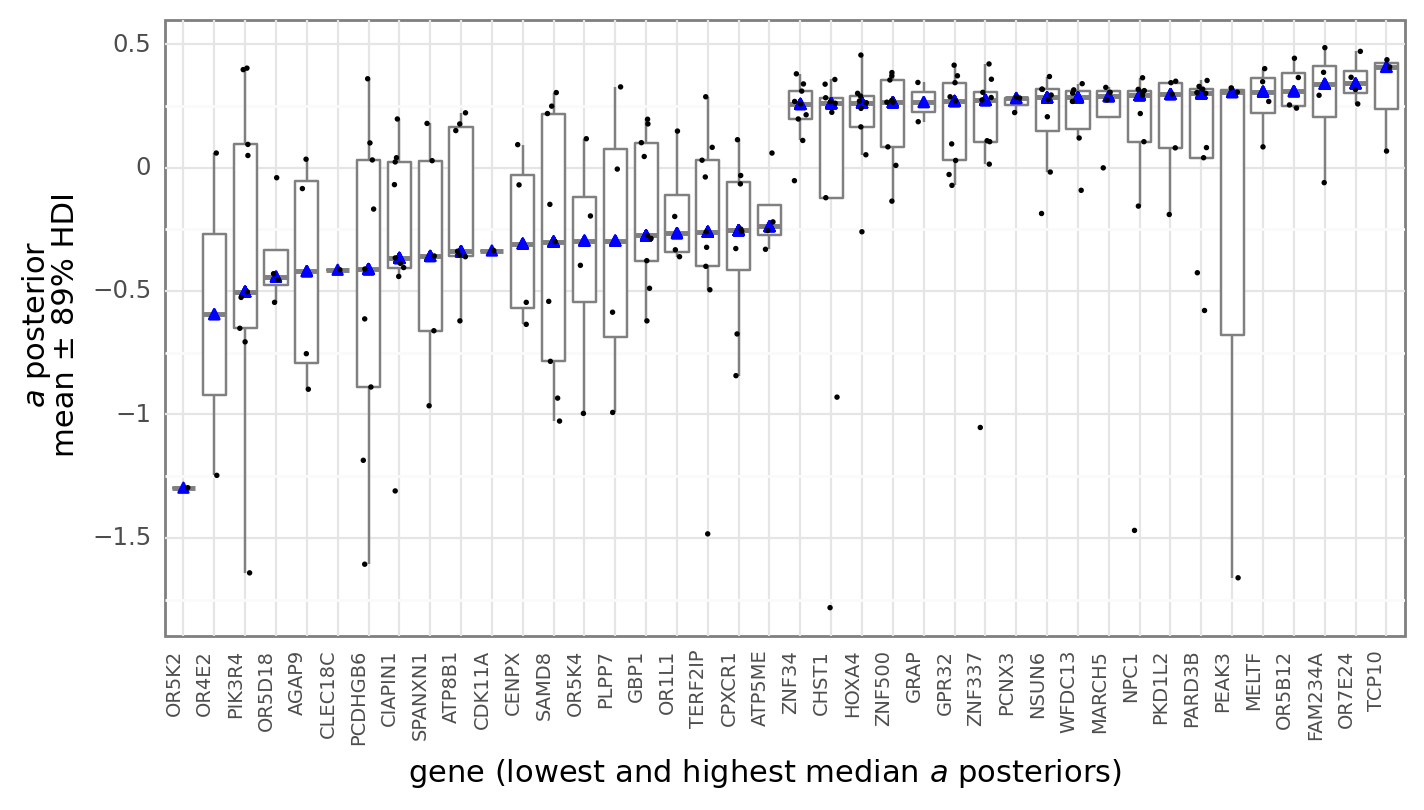

<ggplot: (352211210)>

In [20]:
(
    gg.ggplot(a_post_gene_avg_minmax, gg.aes(x="hugo_symbol"))
    + gg.geom_boxplot(gg.aes(y="mean"), outlier_alpha=0, color="gray")
    + gg.geom_point(gg.aes(y="gene_mean"), shape="^", color="blue")
    + gg.geom_jitter(gg.aes(y="mean"), width=0.2, height=0, size=0.1)
    + gg.theme(
        figure_size=(8, 4), axis_text_x=gg.element_text(angle=90, size=7, hjust=1)
    )
    + gg.labs(
        x="gene (lowest and highest median $a$ posteriors)",
        y="$a$ posterior\nmean ± 89% HDI",
    )
)

#### $d$: gene $\times$ lineage

In [21]:
d_posterior = posterior_summary.query("parameter_name == 'd'").reset_index(drop=True)

_idx = np.asarray(
    [x.replace("]", "").split("[")[1].split(",") for x in d_posterior.parameter],
    dtype=int,
)
d_posterior["hugo_symbol"] = [data_coords["gene"][i] for i in _idx[:, 0]]
d_posterior["lineage"] = [data_coords["lineage"][i] for i in _idx[:, 1]]


d_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,hugo_symbol,lineage
0,"d[0,0]",-0.002,0.038,-0.059,0.060,0.001,0.001,973.0,2159.0,1.00,d,TEKT5,bone
1,"d[0,1]",0.025,0.037,-0.035,0.083,0.001,0.001,911.0,1550.0,1.00,d,TEKT5,colorectal
2,"d[1,0]",-0.001,0.038,-0.059,0.062,0.001,0.001,1319.0,2430.0,1.01,d,HADHA,bone
3,"d[1,1]",0.006,0.038,-0.058,0.065,0.001,0.001,1263.0,2169.0,1.01,d,HADHA,colorectal
4,"d[2,0]",-0.012,0.041,-0.073,0.057,0.001,0.001,2434.0,2330.0,1.00,d,TBC1D24,bone


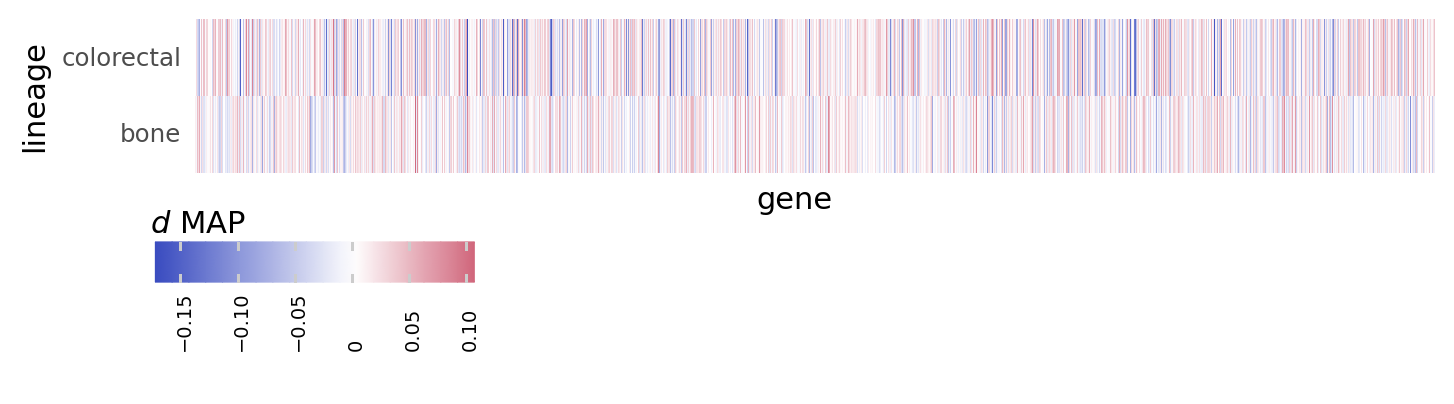

<ggplot: (362625434)>

In [22]:
(
    gg.ggplot(d_posterior, gg.aes(x="hugo_symbol", y="lineage"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#3A4CC0", high="#B30326")
    + gg.theme(
        figure_size=(8, 1),
        axis_text_x=gg.element_blank(),
        legend_position=(0.2, -0.4),
        legend_direction="horizontal",
        legend_key_width=10,
        legend_background=gg.element_blank(),
        legend_text=gg.element_text(angle=90, size=7, va="bottom"),
        panel_background=gg.element_blank(),
        panel_border=gg.element_blank(),
    )
    + gg.labs(x="gene", y="lineage", fill="$d$ MAP")
)

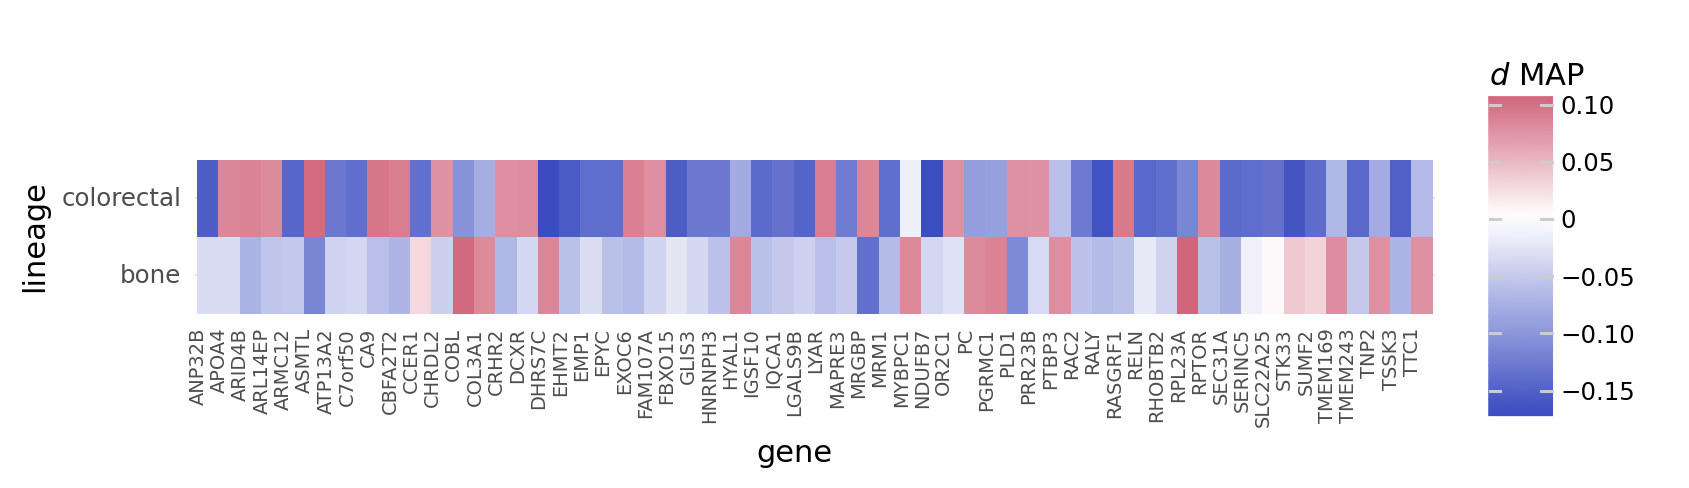

<ggplot: (364500291)>

In [23]:
top_d_genes = d_posterior.sort_values("mean").pipe(min_max, n=30).hugo_symbol.unique()
d_posterior_top = d_posterior.filter_column_isin("hugo_symbol", top_d_genes)

(
    gg.ggplot(d_posterior_top, gg.aes(x="hugo_symbol", y="lineage"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#3A4CC0", high="#B30326")
    + gg.theme(
        figure_size=(8, 1),
        axis_text_x=gg.element_text(angle=90, hjust=1, size=7),
        panel_background=gg.element_blank(),
        panel_border=gg.element_blank(),
    )
    + gg.labs(x="gene", y="lineage", fill="$d$ MAP")
)

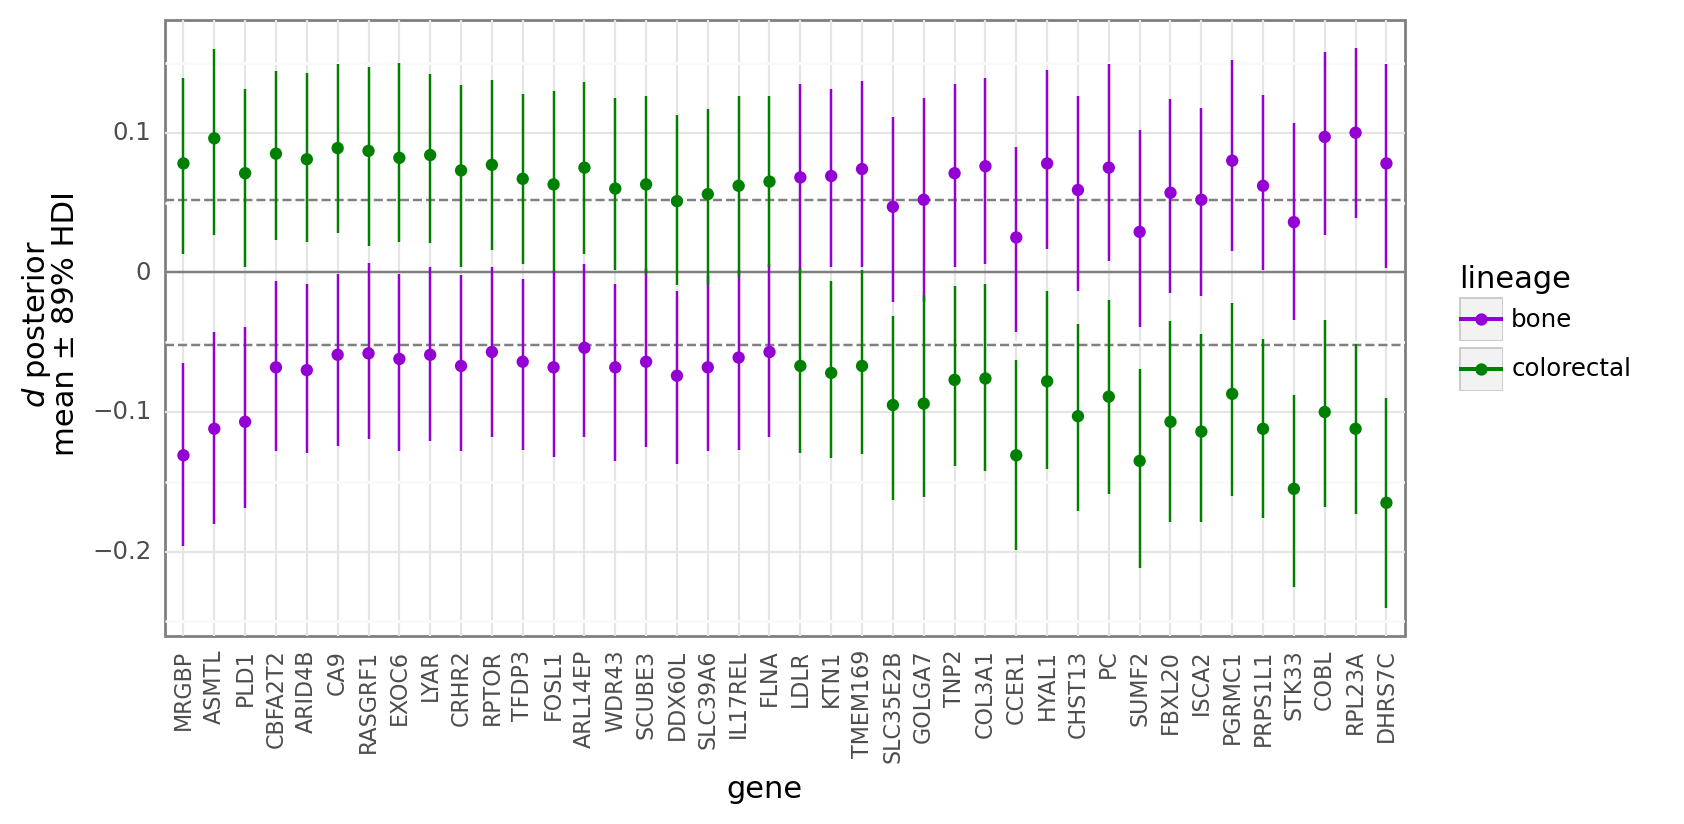

<ggplot: (364778728)>

In [24]:
sigma_d_map = posterior_summary.query("parameter== 'sigma_d'")["mean"].values[0]

d_posterior_diff = (
    d_posterior[["mean", "hugo_symbol", "lineage"]]
    .pivot_wider(index="hugo_symbol", names_from="lineage", values_from="mean")
    .assign(diff=lambda d: d.bone - d.colorectal)
)

most_diff_d = (
    d_posterior_diff.sort_values("diff").pipe(min_max, n=20).hugo_symbol.values
)

plot_df = d_posterior.filter_column_isin("hugo_symbol", most_diff_d).assign(
    hugo_symbol=lambda d: pd.Categorical(
        d.hugo_symbol, categories=most_diff_d, ordered=True
    )
)

(
    gg.ggplot(plot_df, gg.aes(x="hugo_symbol", y="mean", color="lineage"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_hline(yintercept=[-sigma_d_map, sigma_d_map], linetype="--", color="gray")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.geom_point()
    + gg.scale_color_manual(values=lineage_pal)
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=8), figure_size=(8, 4))
    + gg.labs(x="gene", y="$d$ posterior\nmean ± 89% HDI")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 118 rows containing non-finite values.


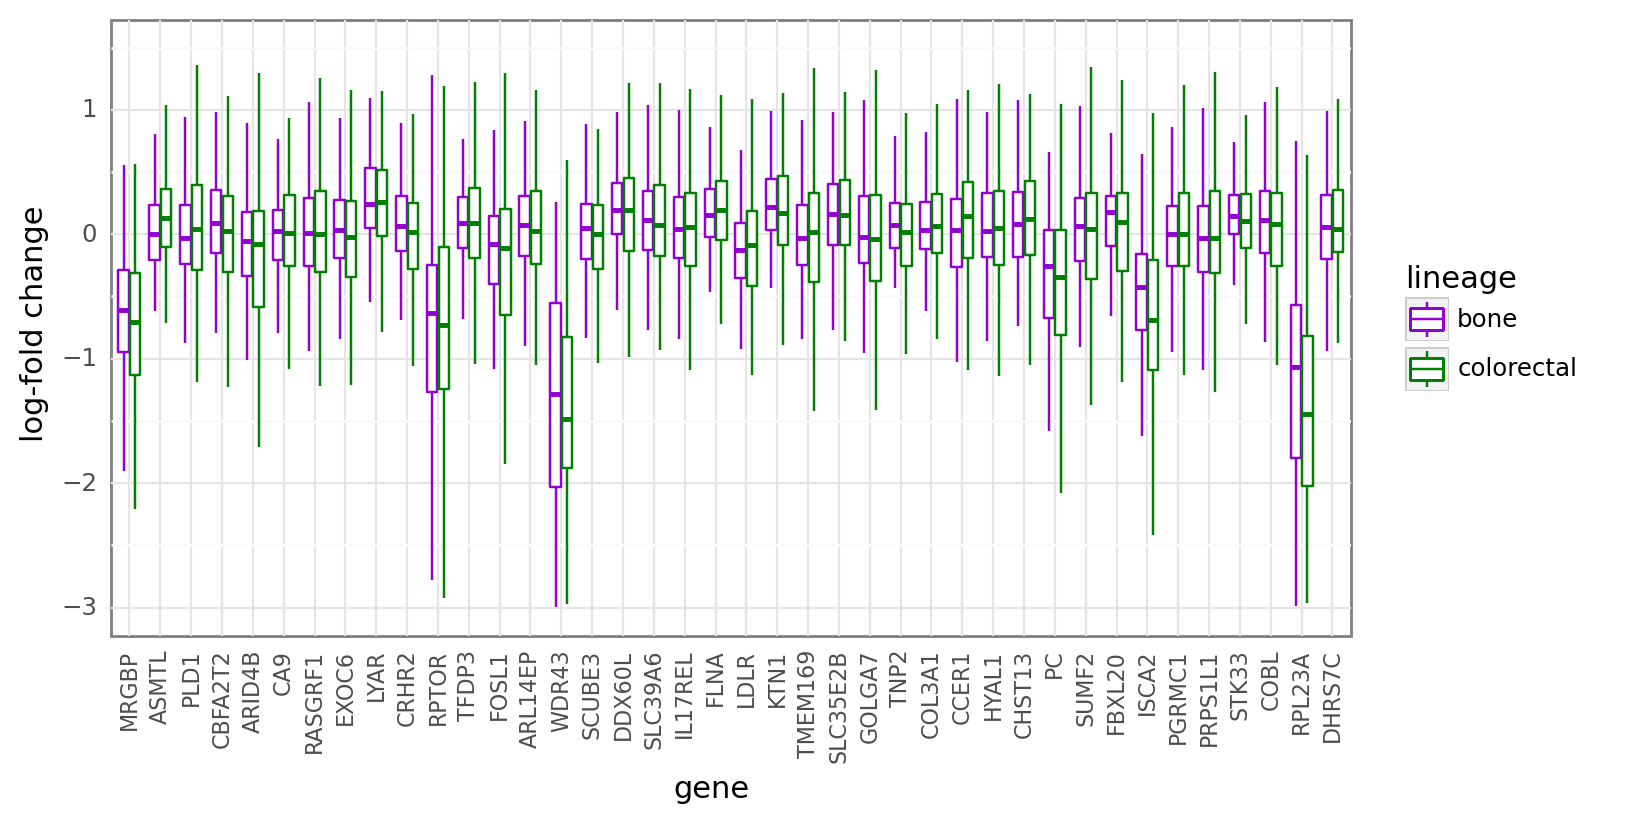

<ggplot: (365168372)>

In [25]:
plot_df = counts_data.filter_column_isin("hugo_symbol", most_diff_d).assign(
    hugo_symbol=lambda d: pd.Categorical(
        d.hugo_symbol, categories=most_diff_d, ordered=True
    )
)
(
    gg.ggplot(plot_df, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(gg.aes(color="lineage"), outlier_alpha=0)
    + gg.scale_color_manual(values=lineage_pal)
    + gg.scale_y_continuous(limits=(-3, 1.5))
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=8), figure_size=(8, 4))
    + gg.labs(x="gene", y="log-fold change")
)

#### $\alpha$: gene dispersion

In [26]:
posterior_summary.filter_string("parameter_name", "_alpha")

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name
21045,alpha_alpha,3.680,0.110,3.512,3.866,0.002,0.001,3324.0,3128.0,1.0,alpha_alpha
21046,beta_alpha,0.529,0.017,0.501,0.555,0.000,0.000,3341.0,2910.0,1.0,beta_alpha


In [27]:
x = np.linspace(0, 20, 500)
alpha = posterior_summary.query("parameter_name == 'alpha_alpha'")["mean"].values[0]
beta = posterior_summary.query("parameter_name == 'beta_alpha'")["mean"].values[0]
pdf = st.gamma.pdf(x, alpha, scale=1.0 / beta)

alpha_parent_dist = pd.DataFrame({"x": x, "pdf": pdf})

In [28]:
alpha_posterior = (
    posterior_summary.query("parameter_name == 'alpha'")
    .reset_index(drop=True)
    .assign(hugo_symbol=data_coords["gene"])
)
alpha_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,hugo_symbol
0,alpha[0],11.514,0.761,10.304,12.702,0.009,0.006,8002.0,2752.0,1.0,alpha,TEKT5
1,alpha[1],9.574,0.647,8.579,10.636,0.008,0.006,6600.0,2627.0,1.0,alpha,HADHA
2,alpha[2],4.555,0.312,4.098,5.082,0.004,0.003,6702.0,2841.0,1.0,alpha,TBC1D24
3,alpha[3],8.987,0.592,8.066,9.936,0.007,0.005,6803.0,2756.0,1.0,alpha,STYX
4,alpha[4],9.101,0.582,8.174,10.002,0.007,0.005,6317.0,2917.0,1.0,alpha,LCMT2


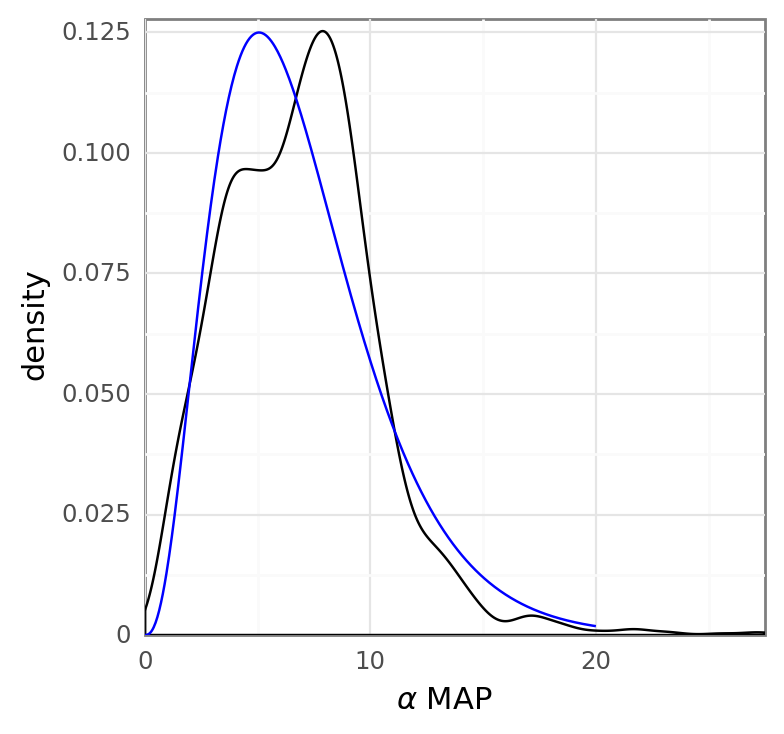

<ggplot: (364746063)>

In [29]:
(
    gg.ggplot(alpha_posterior, gg.aes(x="mean"))
    + gg.geom_density()
    + gg.geom_line(gg.aes(x="x", y="pdf"), data=alpha_parent_dist, color="blue")
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(x="$\\alpha$ MAP")
)

### Posterior predictions

In [30]:
posterior_pred = pd.read_csv(hnb_model_dir / "posterior-predictions.csv").rename(
    columns={"ct_final_dim_0": "data_idx"}
)
posterior_pred.head()

,chain,draw,data_idx,ct_final
0,0,0,0,275
1,0,0,1,943
2,0,0,2,1474
3,0,0,3,65
4,0,0,4,615


In [31]:
ppc_df = pd.concat(
    [
        posterior_pred[["ct_final", "data_idx"]].assign(data="post. pred."),
        counts_data[["counts_final"]]
        .reset_index(drop=False)
        .rename(columns={"index": "data_idx", "counts_final": "ct_final"})
        .assign(data="observed"),
    ]
).astype({"ct_final": int})
ppc_df.head()

,ct_final,data_idx,data
0,275,0,post. pred.
1,943,1,post. pred.
2,1474,2,post. pred.
3,65,3,post. pred.
4,615,4,post. pred.


n_data_pts = ppc_df.data_idx.max()
_sample_size = min(1000, round(n_data_pts * 0.05))
_data_idx = np.random.choice(
    np.arange(0, n_data_pts), size=_sample_size, replace=False
)

(
    gg.ggplot(
        ppc_df.filter_column_isin("data_idx", _data_idx),
        gg.aes(x="ct_final", color="data"),
    )
    + gg.geom_density(alpha=0)
    # + gg.geom_histogram(
    #     gg.aes(y=gg.after_stat("ncount")), size=0, alpha=0.5, position="identity"
    # )
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(
        type="qual", palette="Dark2", guide=gg.guide_legend(override_aes={"alpha": 0.7})
    )
    + gg.theme(
        legend_position=(0.7, 0.5),
        legend_background=gg.element_rect(alpha=0.5),
        figure_size=(6, 4),
    )
)

## Comparing "jitter+adapt_diag" and "advi" chain initialization

In [35]:
advi_post_summ_path = (
    models_dir() / "hierarchical-nb_advi-init_PYMC3_MCMC" / "posterior-summary.csv"
)
advi_post_summ = read_posterior_summary(advi_post_summ_path)
advi_post_summ.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name
0,z,0.040,0.006,0.030,0.050,0.001,0.001,23.0,69.0,1.16,z
1,a[0],0.314,0.085,0.179,0.453,0.001,0.001,7174.0,2973.0,1.00,a
2,a[1],-0.002,0.059,-0.101,0.088,0.001,0.001,3795.0,3032.0,1.00,a
3,a[2],0.177,0.062,0.082,0.280,0.001,0.001,3750.0,2886.0,1.00,a
4,a[3],0.199,0.064,0.098,0.298,0.001,0.001,4707.0,3159.0,1.00,a


In [40]:
combined_post = pd.concat(
    [
        posterior_summary.assign(init_method="jitter+adapt_diag"),
        advi_post_summ.assign(init_method="advi"),
    ]
)
combined_post.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,init_method
0,z,0.042,0.005,0.035,0.050,0.000,0.000,142.0,404.0,1.02,z,jitter+adapt_diag
1,a[0],0.314,0.087,0.165,0.439,0.001,0.001,4659.0,2956.0,1.00,a,jitter+adapt_diag
2,a[1],-0.004,0.060,-0.106,0.085,0.001,0.001,2523.0,3087.0,1.00,a,jitter+adapt_diag
3,a[2],0.179,0.060,0.087,0.279,0.001,0.001,2254.0,2605.0,1.00,a,jitter+adapt_diag
4,a[3],0.196,0.065,0.097,0.303,0.001,0.001,3222.0,2927.0,1.00,a,jitter+adapt_diag


### Sampling diagnostics

#### R-hat

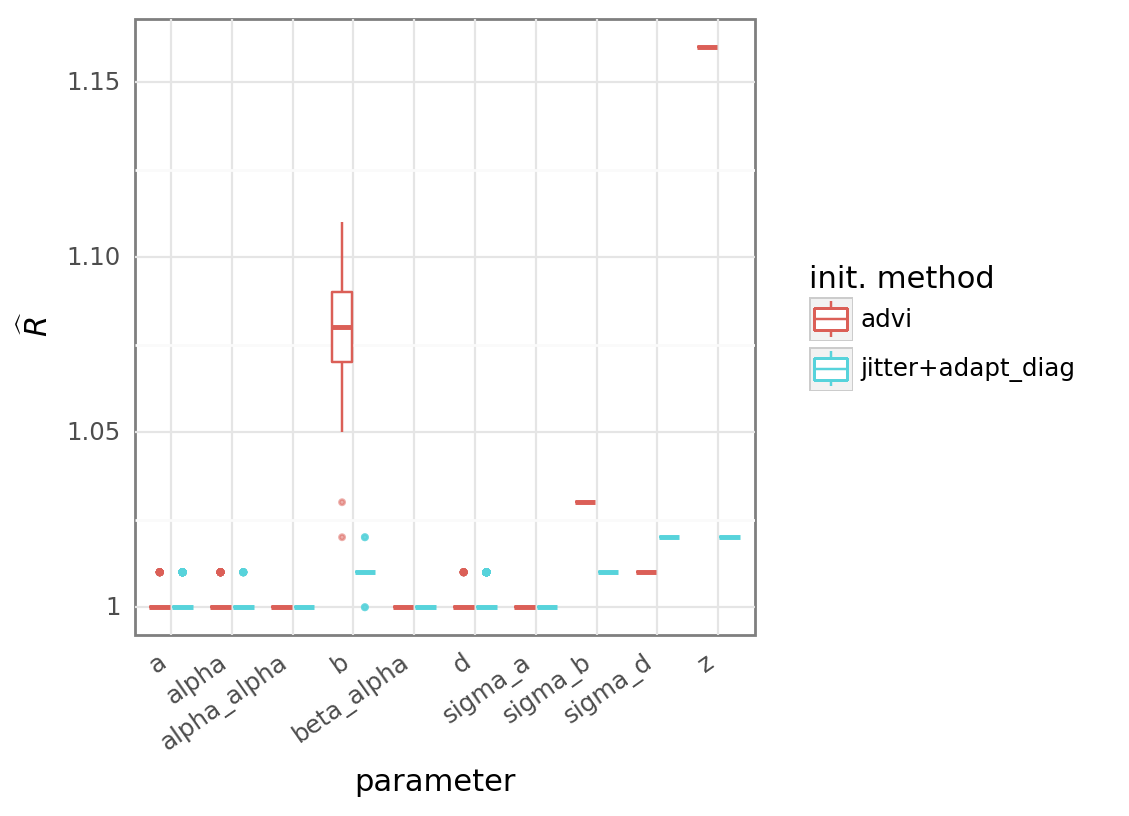

<ggplot: (351148819)>

In [42]:
(
    gg.ggplot(combined_post, gg.aes(x="parameter_name", y="r_hat", color="init_method"))
    + gg.geom_boxplot(outlier_size=0.6, outlier_alpha=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="$\widehat{R}$", color="init. method")
)

#### ESS

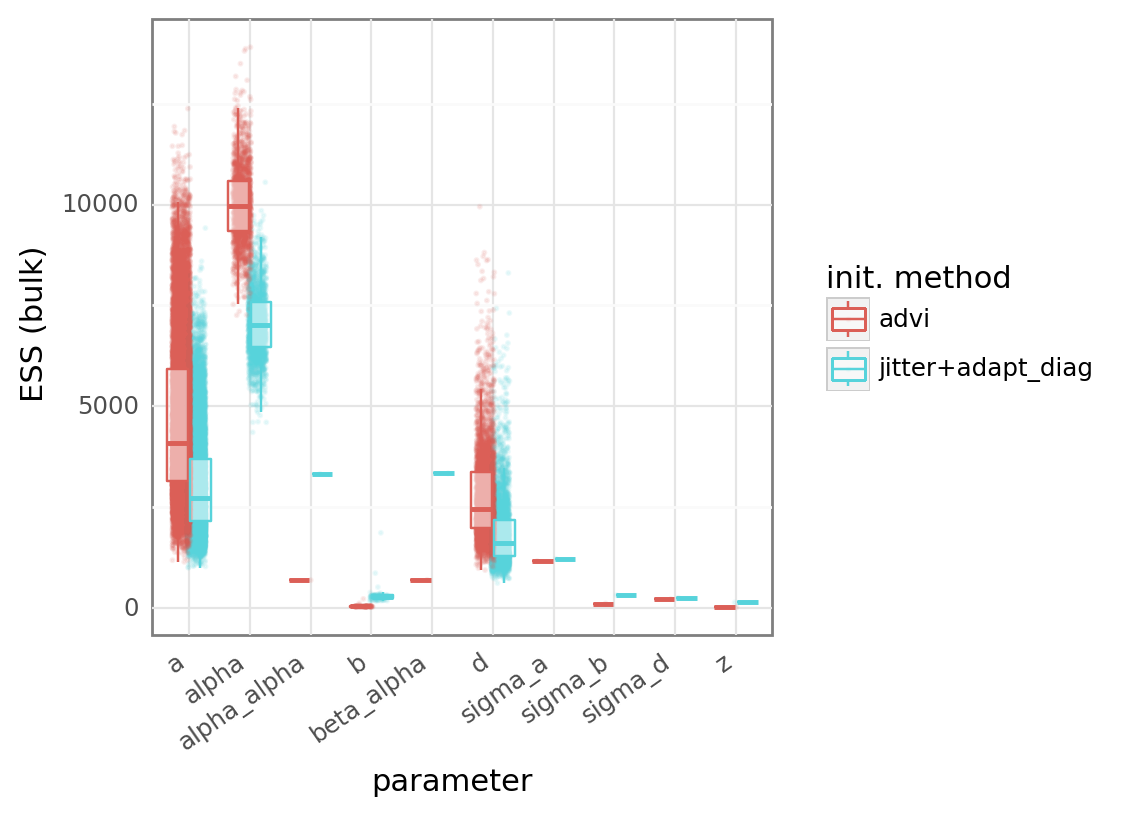

<ggplot: (274383466)>

In [46]:
(
    gg.ggplot(
        combined_post,
        gg.aes(x="parameter_name", y="ess_bulk", color="init_method"),
    )
    + gg.geom_point(
        position=gg.position_jitterdodge(
            jitter_width=0.3, jitter_height=0, dodge_width=0.5
        ),
        alpha=0.1,
        size=0.2,
    )
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="ESS (bulk)", color="init. method")
)

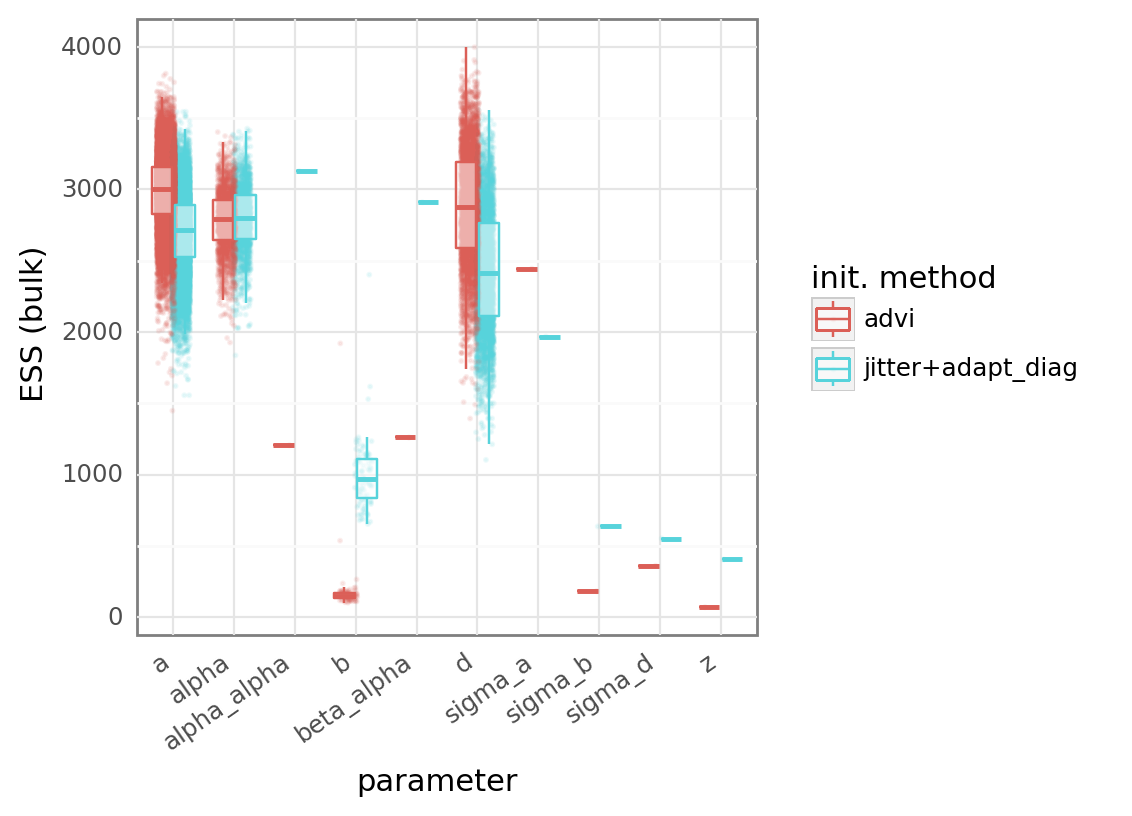

<ggplot: (352438486)>

In [47]:
(
    gg.ggplot(
        combined_post,
        gg.aes(x="parameter_name", y="ess_tail", color="init_method"),
    )
    + gg.geom_point(
        position=gg.position_jitterdodge(
            jitter_width=0.3, jitter_height=0, dodge_width=0.5
        ),
        alpha=0.1,
        size=0.2,
    )
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="ESS (bulk)", color="init. method")
)

### Posterior estimates

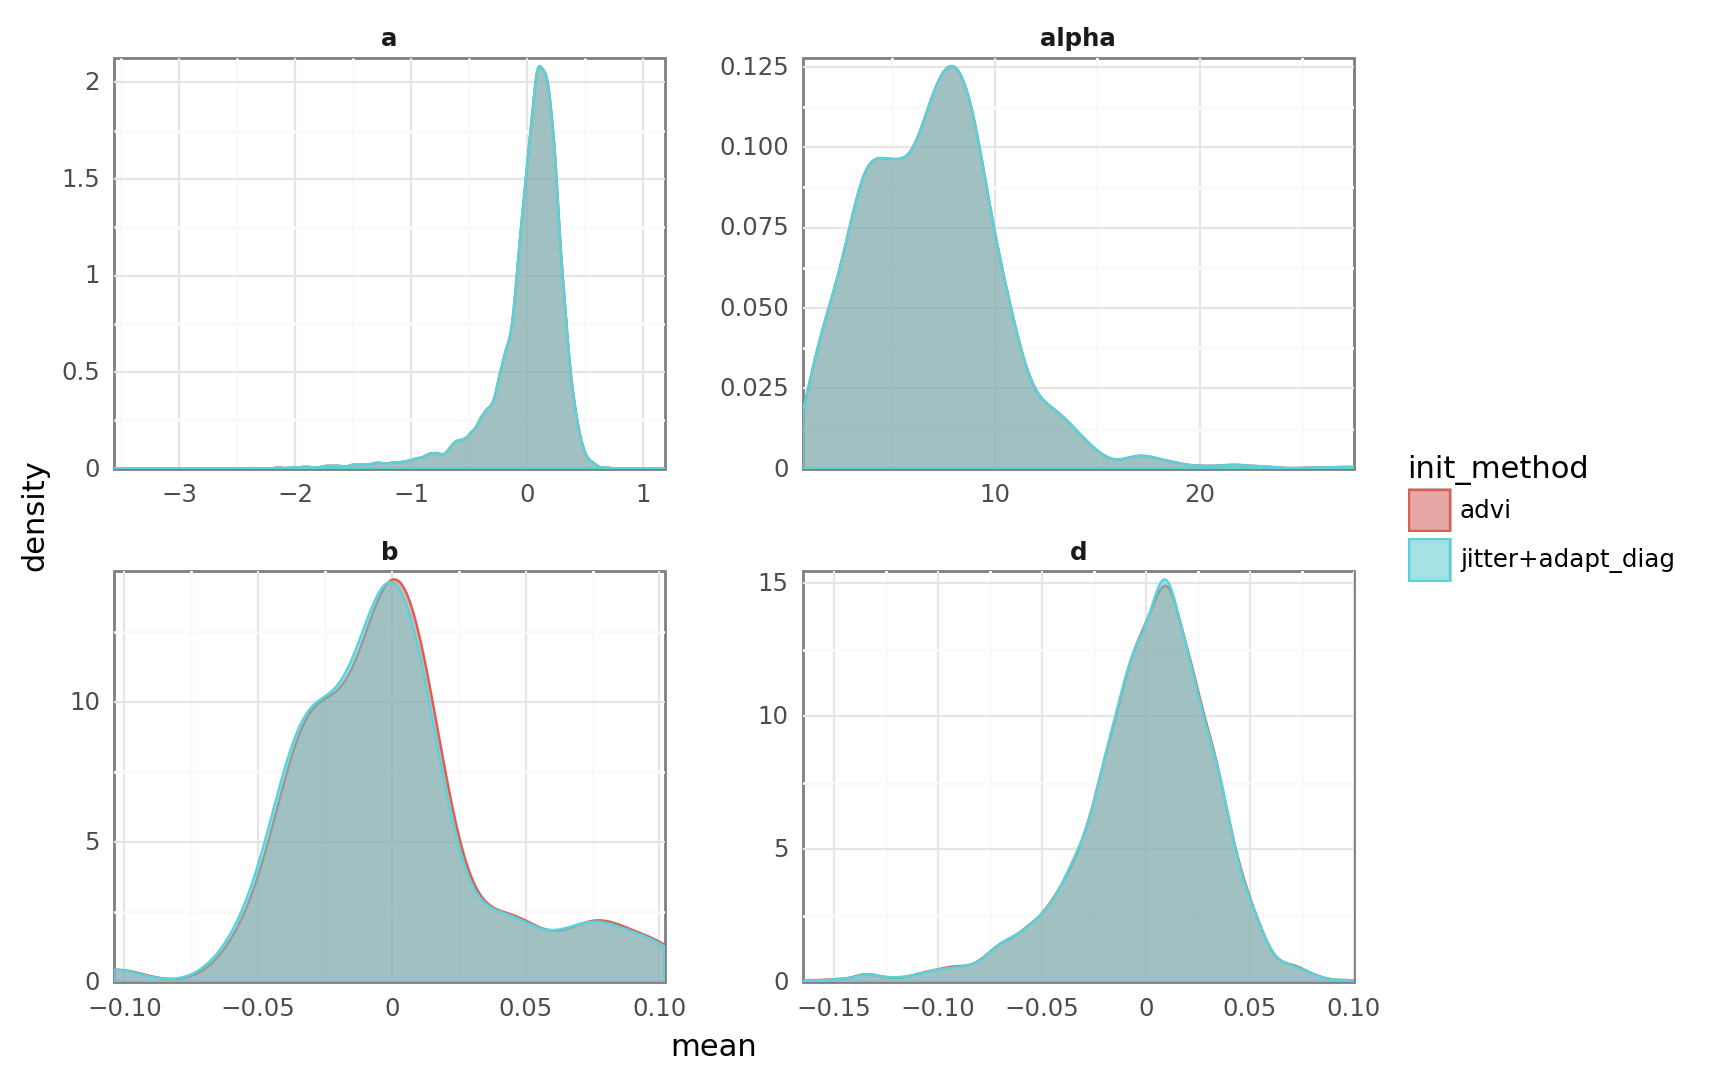

<ggplot: (352790113)>

In [51]:
keep_cols = ["a", "b", "d", "alpha"]
plot_df = combined_post.filter_column_isin("parameter_name", keep_cols)

(
    gg.ggplot(plot_df, gg.aes(x="mean", color="init_method", fill="init_method"))
    + gg.facet_wrap("~parameter_name", nrow=2, scales="free")
    + gg.geom_density(alpha=0.5)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(
        figure_size=(8, 6),
        subplots_adjust={"hspace": 0.25, "wspace": 0.25},
        strip_text=gg.element_text(weight="bold"),
    )
    + gg.labs(x="MAP", y="density", color="init. method", fill="init. method")
)

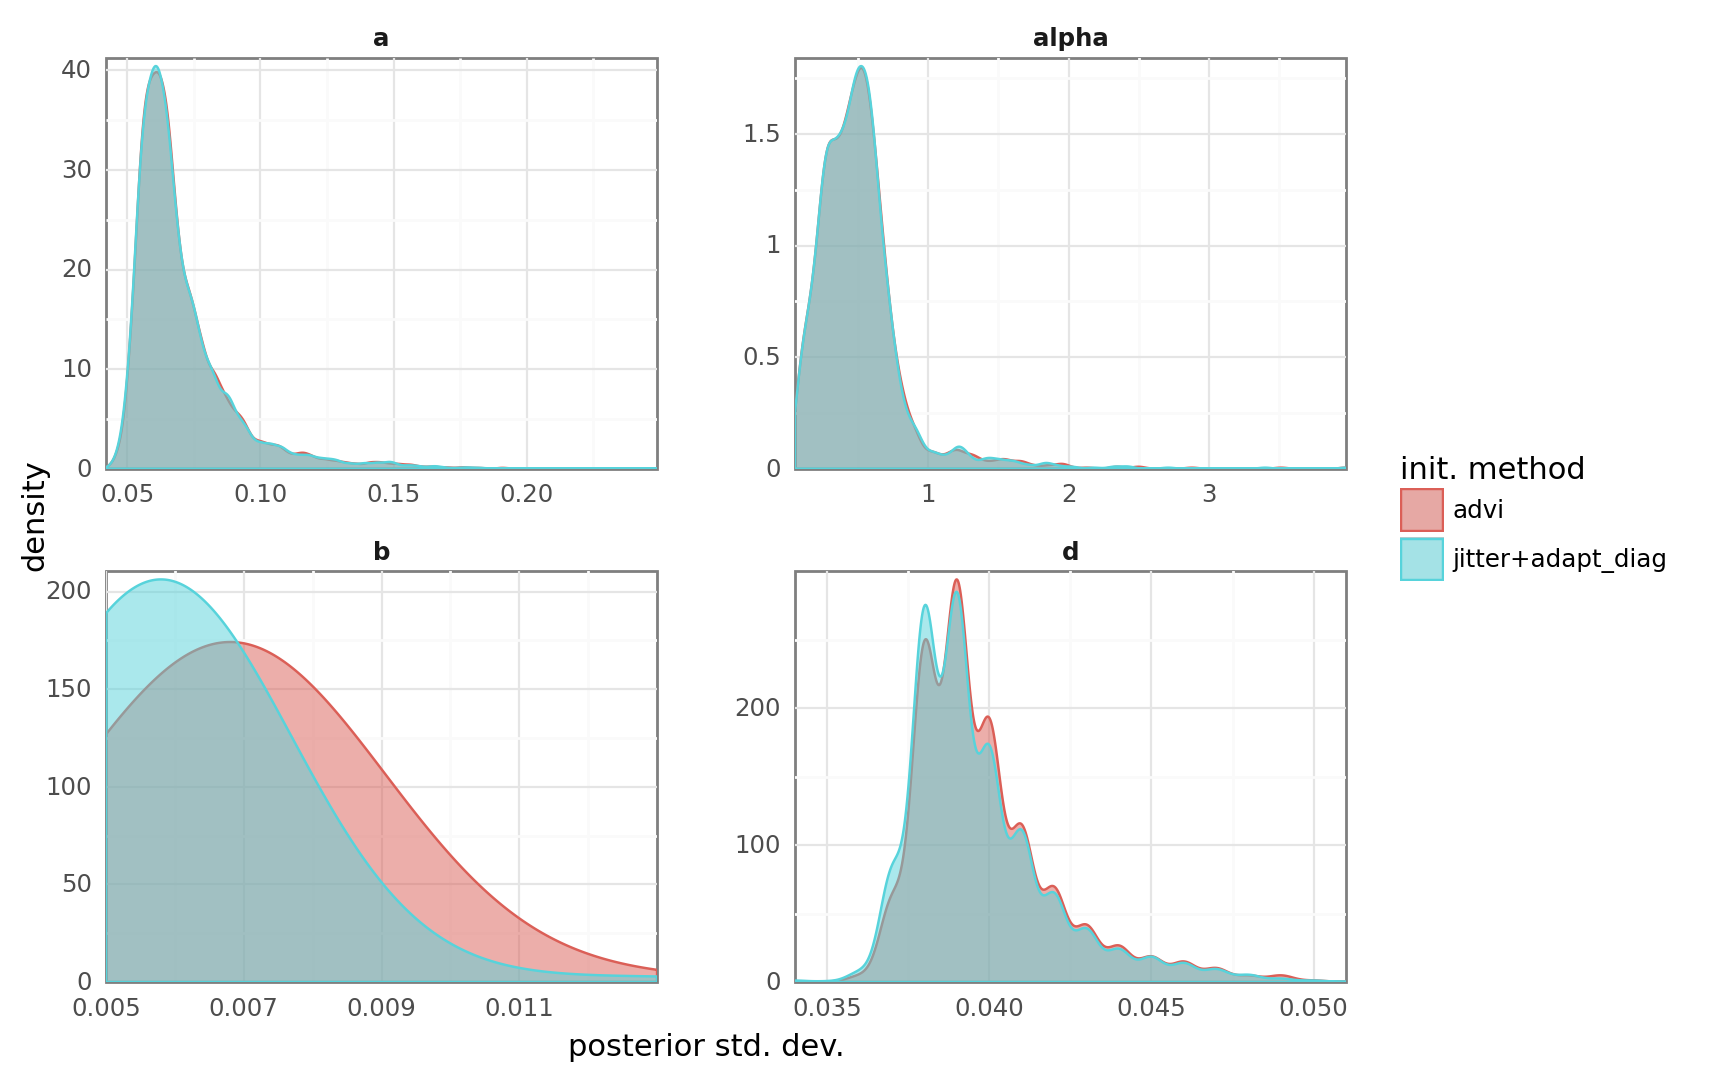

<ggplot: (351007064)>

In [52]:
plot_df = combined_post.filter_column_isin("parameter_name", keep_cols)

(
    gg.ggplot(plot_df, gg.aes(x="sd", color="init_method", fill="init_method"))
    + gg.facet_wrap("~parameter_name", nrow=2, scales="free")
    + gg.geom_density(alpha=0.5)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(
        figure_size=(8, 6),
        subplots_adjust={"hspace": 0.25, "wspace": 0.25},
        strip_text=gg.element_text(weight="bold"),
    )
    + gg.labs(
        x="posterior std. dev.", y="density", color="init. method", fill="init. method"
    )
)

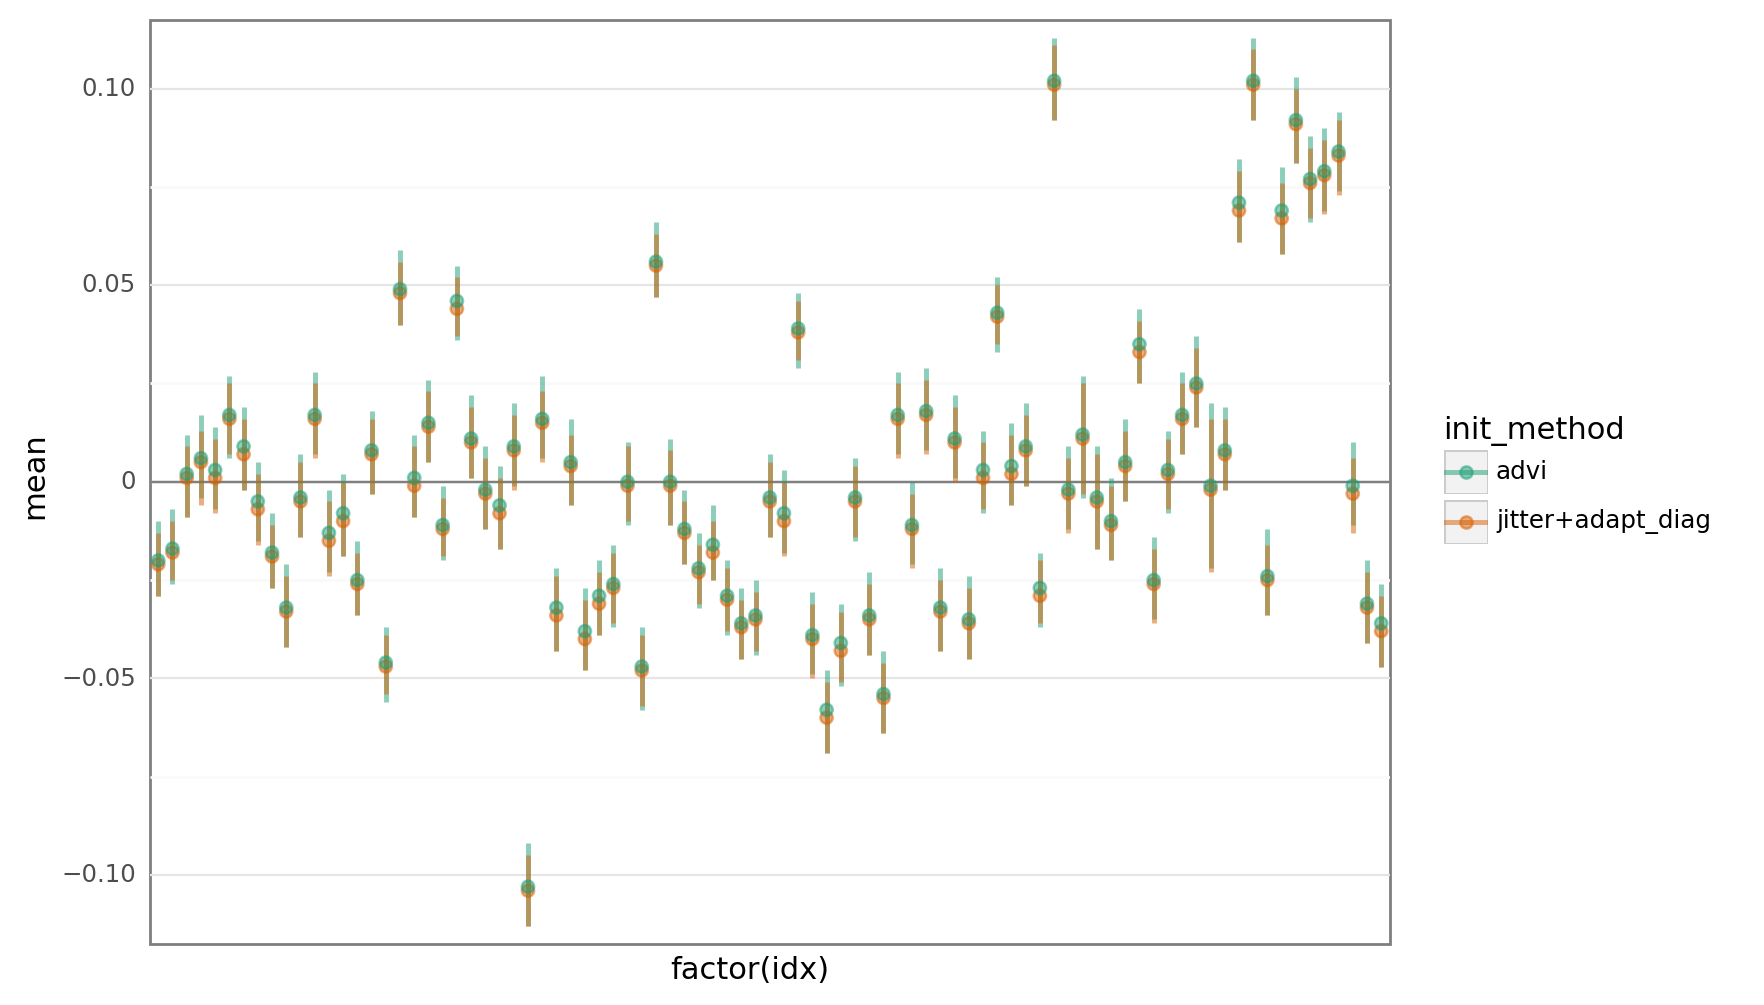

<ggplot: (351140828)>

In [83]:
plot_df = (
    combined_post.query("parameter_name == 'b'")
    .reset_index(drop=True)
    .assign(idx=lambda d: [int(re.findall("[0-9]+", x)[0]) for x in d["parameter"]])
)

(
    gg.ggplot(plot_df, gg.aes(x="factor(idx)", y="mean", color="init_method"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.5, size=1)
    + gg.geom_point(size=2, alpha=0.5)
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(
        figure_size=(8, 6),
        axis_text_x=gg.element_blank(),
        panel_grid_major_x=gg.element_blank(),
    )
)

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.39 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-10

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: theano-blas-warning

pymc3     : 3.11.4
seaborn   : 0.11.2
numpy     : 1.22.0
pandas    : 1.3.5
arviz     : 0.11.4
scipy     : 1.7.3
matplotlib: 3.5.1
plotnine  : 0.8.0

